In [1]:
%%bash
if ! python -c "import quairkit" 2>/dev/null; then
    pip install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple quairkit 
fi

if ! command -v pdftotext &> /dev/null; then
    conda install -y -c conda-forge poppler
fi

# Quantum error mitigation

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

In this tutorial, we mainly introduce quantum error mitigation, including its background and significance. We specifically focus on the probabilistic error cancellation (PEC) method and provide a detailed implementation of the PEC process for depolarizing channels on the QuAIRKit platform.

**Table of Contents**

- [Introduction](#Introduction)
  - [Background](#Background) 
  - [Motivation](#Motivation)
- [Probablistic error cancellation](#Probablistic-error-cancellation)
- [QuAIRKit implementation](#QuAIRKit-implementation)

In [2]:
import torch
import numpy as np

import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')

## Introduction


### Background

Currently, quantum computers remain in the Noisy Intermediate-Scale Quantum (NISQ) era. Limited qubits and imperfect gates introduce noise, reducing the accuracy of quantum algorithms. To address this, researchers proposed Quantum Error Mitigation (QEM). Unlike Quantum Error Correction (QEC), QEM avoids real-time error correction and instead uses post-processing or tailored execution strategies to suppress noise at low hardware cost, making it suitable for NISQ devices [1].

QEM originated in the early 2010s, with early methods including Zero-Noise Extrapolation (ZNE) and Clifford Data Regression (CDR). A core technique, Probabilistic Error Cancellation (PEC), was introduced by Temme et al. in 2017 [2].
 and is based on quasi-probability decomposition, where any quantum channel can be written as a linear combination of physically implementable operations [3].

PEC characterizes the noisy channel, represents its inverse as a weighted sum of implementable operations (possibly with negative weights), and samples them proportionally, canceling noise in expectation while introducing sampling variance.


### Motivation

PEC is used to improve the accuracy of quantum computations on NISQ devices, offering a practical alternative to full error correction. Instead of correcting errors directly, it simulates the inverse of the noise process by probabilistically combining noisy gates, so averaged results approach the ideal outcome. This makes PEC especially useful for algorithms requiring precise expectation values, such as variational algorithms and quantum simulations, without needing fault-tolerant hardware.


## Probablistic error cancellation 



To introduce the procedure of PEC, we first define the problem.

In quantum computation---particularly in the NISQ era---a common computational task is as follows: given an observable $A$ and a quantum state $\rho$, estimate its expectation value $\mathrm{Tr}[\rho A]$.

Without loss of generality, we can assume that $A$ is diagonal in the computational basis; otherwise, we can first apply a unitary transformation to $\rho$ and then perform measurement in the computational basis. That is, we consider measurements of the form
\begin{equation}
A = \sum_{x \in \{0,1\}^n} A(x) \, |x\rangle \langle x|, \quad A(x) \in [-1,1]. 
\end{equation}

If $\rho$ can be perfectly prepared, $\mathrm{Tr}(\rho A)$ can be obtained directly through repeated measurements. However, the preparation of $\rho$ is inevitably subject to noise, which can be modeled by a completely positive trace-preserving (**CPTP**) map $\mathcal{O} \in \mathcal{L}(\mathcal{H})$. As a result, the measured value is actually $\mathrm{Tr}[\mathcal{O}(\rho) A]$.

How can we deal with the noise and recover the true expectation value? We can choose QEM to address this problem.

Since the preparation process is known \textit{a priori}, a feasible approach is to apply its inverse map $O^{-1}$ (assuming it exists), so that
\begin{equation}
\mathrm{Tr}[\mathcal{O}^{-1} \circ \mathcal{O}(\rho) A] = \mathrm{Tr}[\rho A]. \tag{2}
\end{equation}
This would successfully eliminate the noise.

At first glance, this is very similar to the task of quantum channel correction, as $\mathcal{O}^{-1}$ can be regarded as a correction process.

However, the main difficulty is that the inverse map $\mathcal{N} \equiv \mathcal{O}^{-1}$ in (2) may not be physically implementable, i.e., it may not be a CPTP map. According to  Property 1 in [\[4\]](https://doi.org/10.48550/arXiv.2012.10959), $\mathcal{O}$ is both Hermitian-preserving and trace-preserving (**HPTP**), it may still not be directly realizable in practice.

Therefore, the problem we face is: How can we physically approximate the action of an HPTP map?

Such an approximation inevitably incurs additional computational cost. We employ PEC to address this issue.


<figure style="text-align: center;">
  <img src="figures/pec_flowchart.jpg" alt="alt text" width="1000"/>
  <figcaption>Fig.1: PEC procedure.</figcaption>
</figure>


The diagram illustrates the main steps of the PEC procedure.  First, an initial quantum state $\mathcal{O}(\rho)$ is prepared where $\mathcal{O}$ is a noisy channel.  The inverse channel $\mathcal{O}^{-1}$ is then decomposed into a quasi-probability distribution over physically implementable unitaries $\{\mathcal{O}_\alpha\}$.  Each unitary $\mathcal{O}_\alpha$ is sampled according to the normalized absolute value of its coefficient, applied to the noisy state, and the observable $A$ is measured.  The measurement outcome is multiplied by the sign of the corresponding coefficient, and the process is repeated $M$ times.  Averaging all outcomes yields the PEC estimate $\xi$, which approximates the ideal expectation value in the presence of noise.


Next, we present the main procedure of **PEC**:

**1. Quasi-probability decomposition:**  
Decompose the inverse map $\mathcal{N} \equiv \mathcal{O}^{-1}$ into a linear combination of completely positive trace-preserving (CPTP) maps $\{\mathcal{O}_\alpha\}_\alpha$:

$$
\mathcal{N} = \sum_{\alpha} \eta_\alpha \mathcal{O}_\alpha,
$$

such that

$$
2^{\nu(\mathcal{N})} = \sum_{\alpha} |\eta_\alpha|,
$$

where

$$
\nu(\mathcal{N}) := \log \min \left( \sum_{\alpha} |\eta_\alpha| \ \middle|\ 
\mathcal{N} = \sum_{\alpha} \eta_\alpha \mathcal{O}_\alpha,\ \ \mathcal{O}_\alpha \text{ is CPTP},\ \ \eta_\alpha \in \mathbb{R} \right).
$$

Note: According to Theorem 13 [4], this set of CPTP maps is chosen from a group of mutually orthogonal unitary operators.

**2. Sampling and measurement:**  
Repeat the following steps for $m = 1, \dots, M$:

- **(2.1)** Sample a CPTP map $\mathcal{O}^{(m)}$ from the set $\{\mathcal{O}_\alpha\}_\alpha$ with probability

$$
p_\alpha = \frac{|\eta_\alpha|}{\sum_\beta |\eta_\beta|},
$$

and record its corresponding coefficient $\eta^{(m)}$.

- **(2.2)** Apply $\mathcal{O}^{(m)}$ to the noisy state $\mathcal{O}(\rho)$, then perform measurement in the computational basis.  Denote the measurement outcome as a bitstring $s^{(m)} \in \{0,1\}^n$.

**3. Definition of the random variable:**

$$
X^{(m)} = 2^{\nu(\mathcal{N})} \; \mathrm{sgn}(\eta^{(m)}) \; A(s^{(m)}),
$$

where the sign function is defined as

$$
\mathrm{sgn}(x) =
\begin{cases}
-1, & x < 0\\
1, & x \ge 0
\end{cases},
$$

and $A(s^{(m)}) \in [-1,1]$ is the observable value corresponding to the measurement outcome.

**4. Computation of the estimator:**

$$
\xi = \frac{1}{M} \sum_{m=1}^M X^{(m)} 
= \frac{2^{\nu(\mathcal{N})}}{M} \sum_{m=1}^M \mathrm{sgn}(\eta^{(m)}) \; A(s^{(m)}).
$$

Output $\xi$ as the estimator of the target expectation value $\mathrm{Tr}[\rho A]$.

From the following lemma, we know that $\xi$ is an unbiased estimator of the target value:

**Lemma 16** in [4] The random variable
$$
\xi = \frac{1}{M} \sum_{m=1}^M X^{(m)} 
= \frac{2^{\nu(\mathcal{N})}}{M} \sum_{m=1}^M \mathrm{sgn}(\eta^{(m)}) A(s^{(m)})
$$
is an unbiased estimator of $\mathrm{Tr}[\rho A]$.

**Proof:** Denote by $E(X)$ the expectation of a random variable $X$. We have

$$
\begin{aligned}
E(\xi) &= 2^{\nu(\mathcal{N})} \frac{1}{M} \sum_{m=1}^M E \big( \mathrm{sgn}(\eta^{(m)}) A(s^{(m)}) \big) \\[2mm]
&= 2^{\nu(\mathcal{N})} \frac{1}{M} \sum_{m=1}^M \sum_\alpha \frac{|\eta_\alpha|}{2^{\nu(\mathcal{N})}} \mathrm{sgn}(\eta_\alpha) \sum_{s \in \{0,1\}^n} \mathrm{Tr} \big[ \mathcal{O}_\alpha \circ \mathcal{O}(\rho) |s\rangle \langle s| \big] A(s) \\[1mm]
&= 2^{\nu(\mathcal{N})} \frac{1}{M} \sum_{m=1}^M \sum_\alpha \frac{\eta_\alpha}{2^{\nu(\mathcal{N})}} \mathrm{Tr} \big[ \mathcal{O}_\alpha \circ \mathcal{O}(\rho) A \big] \\[1mm]
&= 2^{\nu(\mathcal{N})} \frac{1}{M} \sum_{m=1}^M 2^{-\nu(\mathcal{N})} \mathrm{Tr} \big[ \mathcal{N} \circ \mathcal{O}(\rho) A \big] \\[1mm]
&= \mathrm{Tr}[\rho A].
\end{aligned}
$$

Therefore, as long as $M$ is sufficiently large, by the weak law of large numbers, $\xi$ converges to the true value.


## QuAIRKit implementation 

In this section, we will use **QuAIRKit** to demonstrate how the **PEC** method can mitigate **depolarizing noise**. The depolarizing channel for a single qubit is defined as

$$
\mathcal{D}_{2,\epsilon}(\rho) = \left(1 - \frac{3}{4}\epsilon \right)\rho 
+ \frac{\epsilon}{4} \big( X\rho X + Y\rho Y + Z\rho Z \big),
$$

and its inverse is given by

\begin{equation}
\mathcal{D}_{2,\epsilon}^{-1}(\rho) 
= \frac{4 - \epsilon}{4(1 - \epsilon)}\, \rho 
- \frac{\epsilon}{4(1 - \epsilon)} \big( X\rho X + Y\rho Y + Z\rho Z \big).\tag{3}
\end{equation}

Here, $X, Y, Z$ are the standard Pauli operators, and $\epsilon$ denotes the depolarizing strength.


Based on the form of its inverse (3), we know that we should sample the unitaries
𝐼
,
𝑋
,
𝑌
,
𝑍, we first prepare the circuit required for the PEC procedure.

In [3]:
# --- Define single-qubit Pauli operators ---
I = eye(2)  # Identity operator
X = x()     # Pauli-X operator
Y = y()     # Pauli-Y operator
Z = z()     # Pauli-Z operator

# Stack the unitaries into a single tensor for quasi-probability decomposition
V = torch.stack([I, X, Y, Z], dim=0)  
epsilon = 0.2  # Depolarizing noise strength

# Coefficients for the inverse depolarizing channel (quasi-probabilities)
eta_I = (4 - epsilon) / (4 * (1 - epsilon))      
eta_X = eta_Y = eta_Z = -epsilon / (4 * (1 - epsilon))  
quasi_prob = torch.tensor([eta_I, eta_X, eta_Y, eta_Z])

In this experiment, we prepare an initial single-qubit quantum state and define an observable $A$ to measure. 
The state is then subjected to depolarizing noise, modeled by a single-qubit depolarizing channel. 


In [4]:
# --- Create a single-qubit circuit and apply depolarizing noise ---
cir = Circuit(1)
cir.depolarizing(epsilon)

# --- Prepare a random initial state and a random Hermitian observable A---
rho = random_state(1)
A = random_hermitian(1)

To mitigate the noise, we apply the PEC method: 
we decompose the inverse of the depolarizing channel into a quasi-probability distribution over the Pauli operators $I, X, Y, Z$, 
sample these unitaries according to their normalized absolute weights, 
and compute the expectation value of $A$ using the weighted outcomes. 

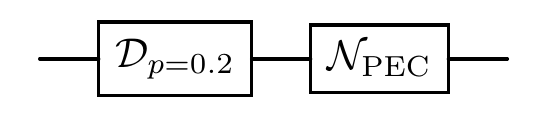

In [5]:
cir.quasi(V, quasi_prob, 0, r'\mathcal{N}_{\text{PEC}}')  # Add quasi-probability decomposition to the circuit
cir.plot()

This procedure allows us to estimate the ideal expectation value in the presence of noise.

In [6]:
output_state = cir(rho)  # a batched state corresponding to each quasi-probability operator
expect_rho = output_state.expec_state()

# --- Compute the PEC expectation value ---
expectation = trace(expect_rho.density_matrix @ A).real.item()

Compare the experimental results with the theoretical values:

In [7]:
# --- Print the results ---
print("PEC estimate =", expectation)

# --- Compute the exact expectation value without noise for comparison ---
expectation_exact = trace(rho.density_matrix @ A).real.item()
print("Exact value =", expectation_exact)

# --- Print the absolute error ---
print("Absolute error =", abs(expectation - expectation_exact))


PEC estimate = 0.7917613846556191
Exact value = 0.7917613846556191
Absolute error = 0.0


---

## References


[1] Temme, Kristan, Sergey Bravyi, and Jay M. Gambetta. "Error mitigation for short-depth quantum circuits." Physical Review Letters 119.18 (2017): 180509.

[2] Endo, Suguru, Simon C. Benjamin, and Ying Li. "Practical quantum error mitigation for near-future applications." Physical Review X 8.3 (2018): 031027.

[3] Cai, Zhenyu, Xiaosi Xu, and Simon C. Benjamin. "Mitigating coherent noise using Pauli conjugation." npj Quantum Information 6.1 (2020): 17.

[4] Jiang, Jiaqing, Kun Wang, and **n Wang. "Physical implementability of linear maps and its application in error mitigation." Quantum 5 (2021): 600.

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
|  $X$ | $\sigma_x$ | Pauli X operator |
|  $Y$ | $\sigma_y$ | Pauli Y operator |
|  $Z$ | $\sigma_z$ | Pauli Z operator |
|  $I$ |  | Identity operator |
|  $\mathcal{N}$ | $\mathcal{O^{-1}}$ | The inverse of the noise channel $\mathcal{O}$. |
|  $A$ |  | Observerble |
|  $E(X)$  |  | The expectation of a random variable $X$ |
|  $\mathcal{L}(\mathcal{H})$  |  | linear operator on the linear space $\mathcal{H}$ |





In [8]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.4
torch: 2.8.0+cpu
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
